In [14]:
!pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf

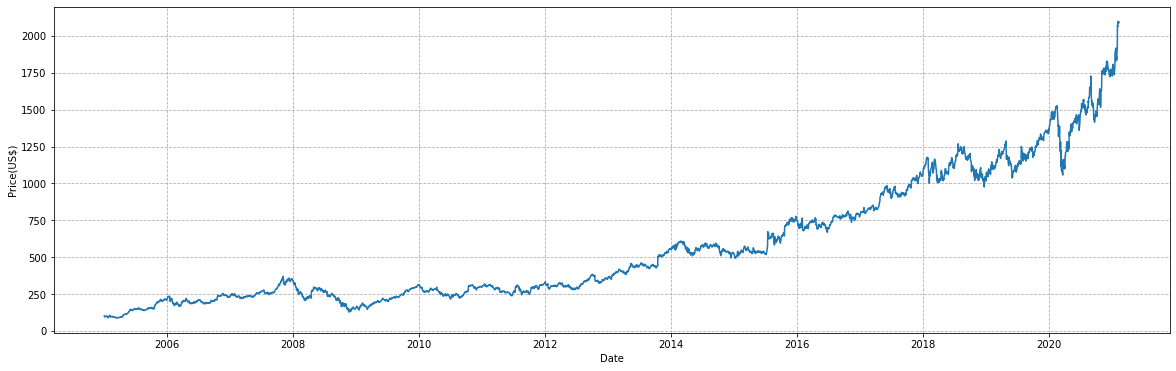

In [15]:
# Download stock data and plot the history diagram

import yfinance as yf
from datetime import datetime, timezone
import pytz

EST = pytz.timezone('US/Eastern')
now = datetime.now()
local_t = now.astimezone(EST)

stockName = "GOOG"
stkTicker = yf.Ticker(stockName)
dfHist = stkTicker.history(start="2005-01-01", end=local_t.strftime('%Y-%m-%d'), interval = "1d")
#np.set_printoptions(threshold=np.inf)
plt.figure(figsize=(20, 6))
plt.grid(ls='--')
plt.xlabel("Date")
plt.ylabel("Price(US$)")
plt.plot(dfHist['Close'])

In [16]:
dfHist['Target'] = np.where(dfHist['Close'].shift(-1) > dfHist['Close'], 1, 0)
dfHist = dfHist[1:]
dfHist = dfHist[['Open','High','Low','Close','Volume','Target']]

In [17]:
# Get train set and test set

from sklearn.model_selection import train_test_split 

dataset = dfHist['Close'].values
target = dfHist['Target'].values
sizeTrain = int(dataset.shape[0]*0.63)
sizeTest = dataset.shape[0] - sizeTrain
#print("The length of data is:",dataset.shape[0], \
#      "\nThe length of Training is:", sizeTrain, \
#      "\nThe length of Testing is:", sizeTest)
xTrain = dataset[ : sizeTrain]
xTest = dataset[sizeTrain : ]
yTrain = target[ : sizeTrain]
yTest = target[sizeTrain :]

In [18]:
from scipy.ndimage.interpolation import shift

def predShiftCov(data, size):
  data = data.flatten()
  out=data.copy()
  for i in range(data.size - size + 1):
    nData = data[i:i+size]
    pattern = shift(nData,-1)
    pattern[size-1]=1
    pattern_1 = pattern.copy() 
    pattern[size-1]=0
    pattern_0 = pattern .copy()
    cov_1 = abs(np.cov(nData, pattern_1)[0,1])
    cov_0 = abs(np.cov(nData, pattern_0)[0,1])
    if cov_1 < cov_0:
      out[i:i+size] = 1
    else:
      out[i:i+size] = 0
  return out

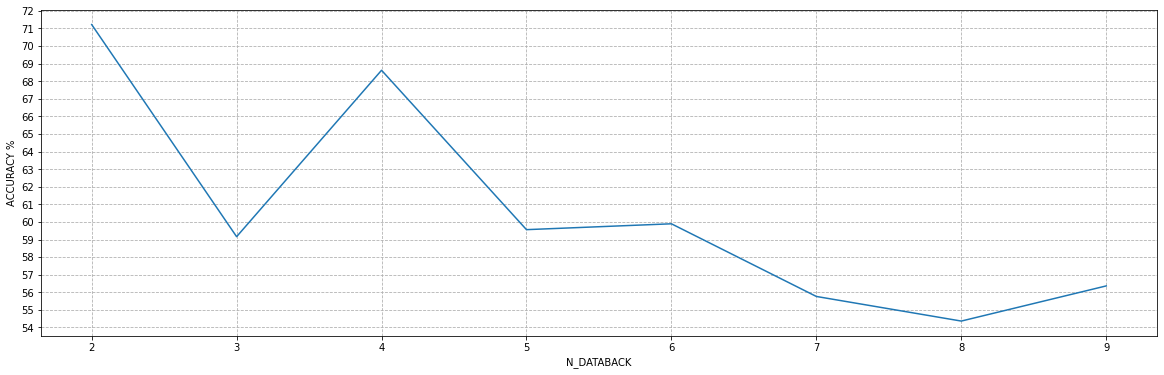

In [19]:
res = []
n = []
MAX_DATABACK = 10
MIN_DATABACK = 2
for i in range (MIN_DATABACK,MAX_DATABACK):
  out = predShiftCov(yTest,i)
  cmp = np.where(shift(out,1) == yTest, 1, 0)
  res.append(cmp.mean()*100)
  n.append(i)

plt.figure(figsize=(20, 6))
plt.grid(ls='--')
plt.xlabel("N_DATABACK")
plt.ylabel("ACCURACY %")
plt.xticks(np.linspace(1, MAX_DATABACK, MAX_DATABACK))
plt.yticks(np.linspace(50, 80, 31))
plt.plot(n,res)

In [31]:
N_DATABACK = 4
pred = predShiftCov(yTest,N_DATABACK)
cmp = np.where(shift(pred,1) == yTest, 1, 0)

In [29]:
def SumRes(pred,close,lever,isPrint):
    pred = pred.flatten()
    close = close.flatten()
    j = 0
    gain = 1
    for i in range(pred.size-1):
        if pred[i] == 1:
          j=j+1
          tmp = (close[i] + lever * (close[i+1]-close[i])) / close[i]
          if tmp <0:
            gain = 0
            tmp = 0
          gain = gain * tmp
          if isPrint ==0:
            print(i, "\tCurrClose:%.02f" %close[i], \
                     "  \tDailyGain:%.02f" % (close[i+1]/close[i]), \
                     "  \tActualGain:%.02f" %(close[i+1]/close[0]), \
                     "  \tPredictedGain:%.02f\n\n" %gain)
    if isPrint ==0 or isPrint ==1:
        print("\tGain Of Prediction = %d\t" %gain,"\n\tGain of Long-term = %.02f" %(close[pred.size-1]/close[0]),"\n\tTrading Times = %d" %j)
    return gain

In [30]:
def dispLever(pred,close):
    MAX_LEVER = 10
    disp  = []
    lever = []
    l = float(1)
    while l<=MAX_LEVER:
        disp.append(SumRes(pred,close,l,2))
        lever.append(l)
        l=l+0.1
    disp = np.array(disp).reshape(-1,1)
    lever = np.array(lever).reshape(-1,1)
    plt.figure(figsize=(20, 6))
    plt.xticks(np.linspace(1, MAX_LEVER, MAX_LEVER))
    plt.grid(ls='--')
    plt.plot(lever, disp)

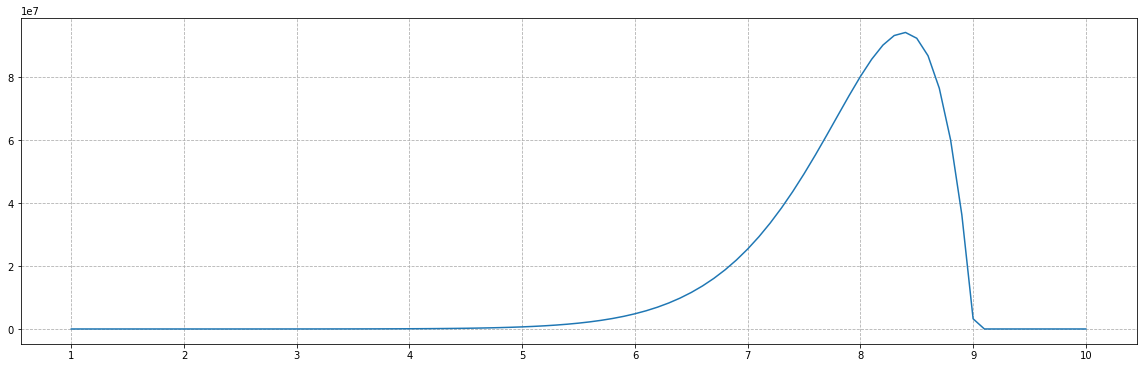

In [35]:
dispLever(pred,xTest)

In [36]:
NDAYS_PRINT = 5 
print("Date from 2005-01-01 to Current\n")
print("\tN_DATABACK =",N_DATABACK, "\n\tACCURACY = %.01f" %(cmp.mean()*100),"%")
gain = SumRes(pred,xTest,5,1)
print("\nToday is",local_t)
print("\tDecision of last days is", pred[-NDAYS_PRINT:])
print("\n")
dfHist[-NDAYS_PRINT:]


Date from 2005-01-01 to Current

	N_DATABACK = 4 
	ACCURACY = 68.6 %
	Gain Of Prediction = 663095	 
	Gain of Long-term = 3.76 
	Trading Times = 709

Today is 2021-02-12 11:24:56.597158-05:00
	Decision of last days is [0 0 0 0 0]




,Open,High,Low,Close,Volume,Target
Date,,,,,,
2021-02-05,2070.000000,2102.510010,2059.330078,2098.000000,1533900,0
2021-02-08,2105.909912,2123.547119,2072.000000,2092.909912,1241900,0
2021-02-09,2078.540039,2105.129883,2078.540039,2083.510010,889900,1
2021-02-10,2094.209961,2108.370117,2063.090088,2095.379883,1135500,1
2021-02-11,2099.510010,2102.030029,2077.320068,2095.889893,945200,0
